# Imports

In [51]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


from rfpimp import *

In [53]:
# north star metric is micro f1_score per the competition
scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True, average='micro')

# Functions and Class creations

Data processing functions
---

In [54]:
def create_X(df):
    """Returns the tidy version on pandas Dataframe
    Label Encodes the categorical columns.

    Parameters
    ----------
    df : pandas DataFrame

    Returns
    -------
    X : pandas DataFrame

    """
    X = df.copy()
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]

    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)

    return X


def _new_ids(l1, l2):
    """ Replaces elements in l2 not in l1
    with the mode of l1. Helpful to handle new 
    categorical values during testing of algorithms.

    Parameters
    ----------
    l1 : np.array
    l2 : np.array

    Returns
    -------
    out : np.array

    """

    if not isinstance(l1, np.ndarray):
        l1 = np.array(l1)
    if not isinstance(l2, np.ndarray):
        l2 = np.array(l2)

    mode = scipy.stats.mode(l1)[0][0]  # mode value of train

    bool_arr = np.array([i in l1 for i in l2])
    out = l2.copy()
    out[~bool_arr] = mode

    return out


def replace_new_ids(train_df, test_df, cols):
    """ This function will replace any new values in the cols of 
    test_df with the mode correponding cols in train_df

    Parameters
    ----------
    train_df : pandas.DataFrame
    test_df  : pandas.DataFrame
    cols     : list

    Returns
    -------
    train_df : pandas.DataFrame
    test_df  : pandas.DataFrame
               test_df with new values replaced.

    """

    for column in cols:
        test_df.loc[:, column] = _new_ids(
            train_df.loc[:, column], test_df.loc[:, column])
    return train_df, test_df


def geo23_in_geo1(X_train, X_test):
    """ Creates features count12 and count13 in both
    X_train, X_test.


    Requirement: No new geo_level_2 ids in X_test

    Parameters
    ----------
    train_df : pandas.DataFrame
    test_df  : pandas.DataFrame
    cols     : list

    Returns
    -------
    train_df : pandas.DataFrame
    test_df  : pandas.DataFrame
               test_df with new values replaced.

    """

    dic_1_2 = dict(X_train.groupby('geo_level_1_id', as_index=False)[
                   'geo_level_2_id'].nunique())
    dic_1_3 = dict(X_train.groupby('geo_level_1_id', as_index=False)[
                   'geo_level_3_id'].nunique())

    for frame in [X_train, X_test]:
        frame['count12'] = frame.loc[:, 'geo_level_1_id'].apply(
            lambda x: dic_1_2[x])
        frame['count13'] = frame.loc[:, 'geo_level_1_id'].apply(
            lambda x: dic_1_3[x])

    return X_train, X_test

Frequency encoding Class
----

In [55]:
class FreqEncode:
    def __init__(self):
        self.freq_dict = {}

    def create_dict(self, train_col):
        return dict(train_col.value_counts())

    def fit(self, X_train, cols):
        '''
        X_train = train_df
        cols for which we need to encode frequency
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i])
            self.freq_dict[i] = value

    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_fq'] = X_test[i].apply(lambda x: self.freq_dict[i][x])
        return X_test

## Data Import

In [56]:
df = pd.read_csv('input/train_values.csv')
X = create_X(df)
train_target = pd.read_csv('input/train_labels.csv')
y = train_target.damage_grade

In [57]:
X.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,802906,6,487,12198,2,30,6,5,1,1,...,0,0,2,2,0,0,1,3,2,2
1,28830,8,900,2812,2,10,8,7,0,1,...,0,0,1,2,0,3,1,2,2,2
2,94947,21,363,8973,2,10,5,5,0,1,...,0,0,2,2,0,0,3,3,2,2
3,590882,22,418,10694,2,10,6,5,0,1,...,0,0,2,2,0,0,3,2,2,2
4,201944,11,131,1488,3,30,8,9,1,0,...,0,0,2,2,0,0,3,2,2,2


# Model Building

In [58]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

Baseline model using Mode of 2 with multiple metric eval
---

In [59]:
y_true = train_target.damage_grade
y_pred = [2]*len(y_true)

In [60]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

In [61]:
f1_score(y_true, y_pred, average='macro')

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.24174371015343477

In [62]:
precision_score(y_true, y_pred, average='macro')

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.18963728714266892

In [63]:
recall_score(y_true, y_pred, average='macro')

0.3333333333333333

Pipeline with micro f1 as scorer and north star metric, same as competition eval
---

In [64]:
logr_pipe = Pipeline([('scl', StandardScaler()),
                      ('log', LogisticRegression(solver='saga', n_jobs=-1))])
knn_pipe = Pipeline([('scl', StandardScaler()),          # Transformer: Standardize
                     ('knn', KNeighborsClassifier(n_neighbors=3, n_jobs=-1))])
rf_pipe = Pipeline([('clf', RandomForestClassifier(n_jobs=-1))])
dt_pipe = Pipeline([('dtree', DecisionTreeClassifier())])

In [65]:
pipelines = [logr_pipe, knn_pipe, rf_pipe, dt_pipe]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)  # One-liners fits all models
# Compare accuracies
for pipe in pipelines:
    # Fluent like a boss
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    print(f"{name:<22}: {pipe.score(X_test, y_test):.2%}")

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression    : 58.42%
KNeighborsClassifier  : 61.44%
RandomForestClassifier: 69.52%
DecisionTreeClassifier: 64.66%


We will go with RF Classifier
---

In [68]:
model = RandomForestClassifier(
    n_estimators=150, min_samples_leaf=3, n_jobs=-1, oob_score=True)

In [69]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [70]:
model.oob_score_

0.7216279739063699

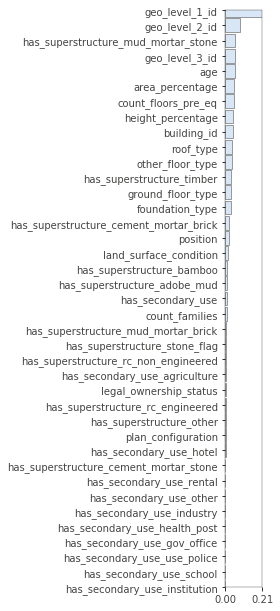

In [71]:
imp = importances(model, X_train, y_train)  # permutation
viz = plot_importances(imp)

In [72]:
cross_val_score(estimator=model, X=X_test, y=y_test,
                scoring=scorer, cv=3, n_jobs=-1)

array([0.69283453, 0.69287441, 0.69301174])

## Geo level ID is very important, lets try some feature engineering with it

In [73]:
X, _ = geo23_in_geo1(X, X)
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
X, _ = replace_new_ids(X, X, geo_features)
fe = FreqEncode()
fe.fit(X, geo_features)
X = fe.transform(X)

In [74]:
# get new train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

0.742157521105142


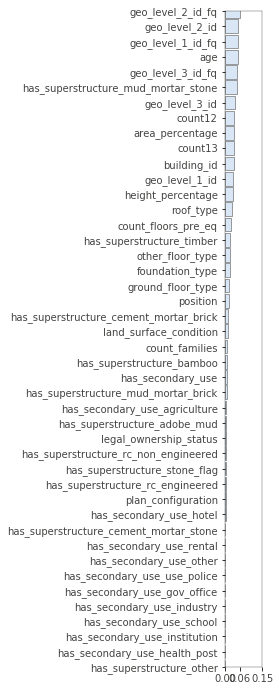

In [75]:
model2 = RandomForestClassifier(
    n_estimators=150, min_samples_leaf=3, oob_score=True, n_jobs=-1)
model2.fit(X_train, y_train)
print(model2.oob_score_)
imp = importances(model2, X_train, y_train)  # permutation
viz = plot_importances(imp)

##### Take top 20 features, refit

In [76]:
top20 = imp.iloc[:20].index.tolist()
top20.remove('building_id')

In [77]:
model2.fit(X_train[top20], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [78]:
cross_val_score(estimator=model2,
                X=X_train[top20], y=y_train, scoring=scorer, cv=3, n_jobs=-1)

array([0.73920426, 0.74092355, 0.74161055])

In [79]:
model2.oob_score_

0.742886607828089

Big improvement on rf results using geo id freq encoding. Now tune hyperparameters
---

In [80]:
rf = RandomForestClassifier()
params = {'n_estimators': [20, 50, 100, 150, 200],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [3, 5, 10, 25, 100],
          'max_features': ['sqrt', 'log2', 8]}
n_iter = 7

In [81]:
rand_rf = RandomizedSearchCV(rf, param_distributions=params, scoring='f1_micro', n_iter=n_iter, cv=3,
                             n_jobs=-1)

In [82]:
rand_rf.fit(X_train[top20], y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [83]:
pd.DataFrame(rand_rf.cv_results_).drop(['mean_fit_time', 'std_fit_time',
                                        'mean_score_time', 'std_score_time', 'params'], axis=1).T

,0,1,2,3,4,5,6
param_n_estimators,200,100,20,20,50,100,20
param_min_samples_leaf,10,5,3,10,10,3,5
param_max_features,log2,sqrt,8,sqrt,log2,log2,8
param_criterion,gini,entropy,entropy,entropy,entropy,gini,entropy
split0_test_score,0.733851,0.736197,0.731938,0.729664,0.729837,0.739348,0.737118
split1_test_score,0.734534,0.736448,0.735686,0.728807,0.731412,0.740262,0.738765
split2_test_score,0.734142,0.738128,0.735495,0.731135,0.732703,0.740243,0.738214
mean_test_score,0.734176,0.736924,0.734373,0.729869,0.731317,0.739951,0.738032
std_test_score,0.000279886,0.000857317,0.00172364,0.00096106,0.0011721,0.000426401,0.00068471
rank_test_score,5,3,4,7,6,1,2


In [84]:
rand_rf.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'criterion': 'gini'}

In [85]:
rand_rf.best_score_

0.7399510744435918

# Results and Summary of Best Model

In [91]:
rand_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

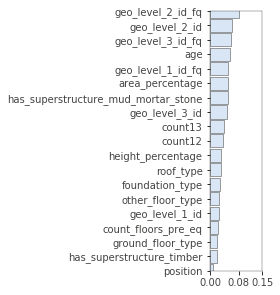

In [87]:
imp = importances(rand_rf.best_estimator_,
                  X_train[top20], y_train)  # permutation
viz = plot_importances(imp)

Other eval metrics, compared to base model using mode
---

In [88]:
y_model_pred = rand_rf.predict(X_test[top20])
f1_score(y_test, y_model_pred, average='macro')

0.68722985107045

In [89]:
precision_score(y_test, y_model_pred, average='macro')

0.7357495849271798

In [90]:
recall_score(y_test, y_model_pred, average='macro')

0.6582076256351449

# Takeaways and Summary

* Feature engineering is very important as we increased our score enough through this to get into the top 50 

* Current model is able to predict the right label around 75% of the times.  

* Government would be able to disburse the funds faster.

* Geographical Features are the most important for improving the accuracy.

* Age is also very important, so in earthquake prone areas it is important to check on older buildings more often
